networkx-temporal
---

[PyPI package](https://pypi.org/p/networkx-temporal/) | [Documentation](https://networkx-temporal.readthedocs.io/en/latest) | [GitHub repository](https://github.com/nelsonaloysio/networkx-temporal)

In [1]:
!pip install -q leidenalg matplotlib networkx networkx-temporal python-igraph

In [2]:
%load_ext autoreload
%autoreload 2
import networkx as nx
import networkx_temporal as tx

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


___

### Build temporal graph

The main class of the package is the `TemporalGraph` object, which extends `networkx.Graph` to handle temporal data.

Let's start by creating a simple directed graph using ``time`` as attribute key:

In [3]:
TG = tx.TemporalGraph(directed=True)  # multigraph=True

TG.add_edge("a", "b", time=0)
TG.add_edge("c", "b", time=1)
TG.add_edge("d", "c", time=2)
TG.add_edge("d", "e", time=2)
TG.add_edge("a", "c", time=2)
TG.add_edge("f", "e", time=3)
TG.add_edge("f", "a", time=3)
TG.add_edge("f", "b", time=3)

TG

TemporalDiGraph with 6 nodes and 8 edges

Note that the resulting graph object reports a **single** time step ``t=1``, as it haven't yet been sliced.

> By default, graphs created with the package allow multiple edges between the same pair of nodes ([MultiGraph](https://networkx.org/documentation/stable/reference/classes/multigraph.html)). This is particularly useful for temporal graphs, as it allows to store multiple interactions between the same nodes at different time steps within a single graph object. This behavior can be changed by setting ``multigraph=False`` when creating the ``TemporalGraph`` object.

### Slice temporal graph

We may now call `slice` to split the graph we created into a number of snapshots:

In [4]:
TG = TG.slice(attr="time")
TG

TemporalDiGraph (t=4) with 12 nodes and 8 edges

We may further inspect the temporal graph's properties using the following methods:

In [5]:
print(f"t = {len(TG)} time steps\n"
      f"V = {TG.order()} nodes ({TG.temporal_order()} unique, {TG.total_nodes()} total)\n"
      f"E = {TG.size()} edges ({TG.temporal_size()} unique, {TG.total_edges()} total)")

t = 4 time steps
V = [2, 2, 4, 4] nodes (6 unique, 12 total)
E = [1, 1, 3, 3] edges (8 unique, 8 total)


Let's now visualize the resulting temporal graph using the `draw_temporal_graph` function:

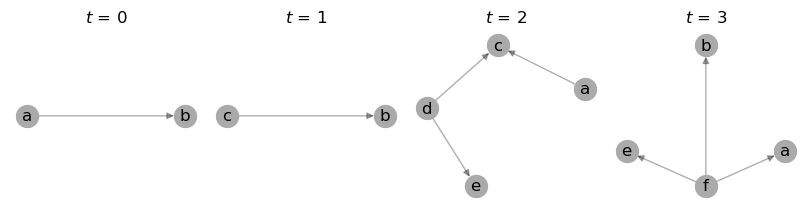

In [6]:
tx.draw(TG, layout="kamada_kawai", figsize=(8, 2))

> The `draw_temporal_graph` function currently simply calls `networkx`
> [draw](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html)
> in the backend and is meant only as an example to showcase the package’s capabilities. It does not scale well
> to large graphs, which usually require more sophisticated approaches or specialized visualization tools.

### Specify number of snapshots

A specific number of bins can be returned in a new object of the same type using ``slice``:

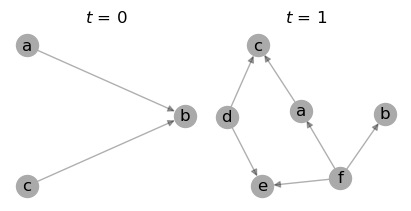

In [7]:
TG = TG.slice(attr="time", bins=2)
tx.draw(TG, layout="kamada_kawai", figsize=(4, 2))

Note that this usually leads to snapshots with differing numbers of nodes and edges, as expected.

#### Considering quantiles

By default, created bins are composed of non-overlapping edges and might have uneven order and/or size.

To try and balance them using quantiles, pass ``qcut=True`` (see [pandas.qcut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html) for details):

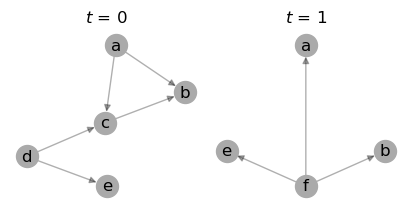

In [8]:
TG = TG.slice(attr="time", bins=2, qcut=True)
tx.draw(TG, layout="kamada_kawai", figsize=(4, 2))

Though not perfectly balanced due to node $a$ appearing multiple times (in $t=\{1,2,3\}$),
the resulting snapshots have a more even number of edges. Results are expected to vary in a case-by-case basis.

#### Considering order of appearance

Forcing a number of bins can be achieved by setting ``rank_first=True``, therefore considering the order of appearance of nodes or edges.

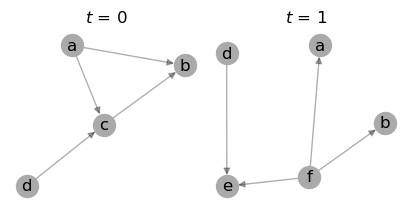

In [9]:
TG = TG.slice(attr="time", bins=2, rank_first=True)
tx.draw(TG, layout="kamada_kawai", figsize=(4, 2))

As the `time` attribute is here located in the edge level, each resulting snapshot has 4 edges each.

In case of node-level times, the number of nodes in each snapshot would be more evenly distributed.

> In some cases, ``slice`` may still not be able to split the graph into the number of bins requested (e.g., insufficient data), returning the maximum possible number of temporal snapshots instead.

### Convert from static graph

Static graphs may carry temporal information in both node- and edge-level attributes.

Slicing a graph into bins usually result in the same number of edges, but a higher number of nodes, as they may appear in more than one snapshot.

In the example below, we create a static multigraph in which both nodes and edges are attributed with the time step in which they are observed:

In [10]:
G = nx.MultiDiGraph()

G.add_nodes_from([
    ("a", {"time": 0}),
    ("b", {"time": 0}),
    ("c", {"time": 1}),
    ("d", {"time": 2}),
    ("e", {"time": 3}),
    ("f", {"time": 3}),
])

G.add_edges_from([
    ("a", "b", {"time": 0}),
    ("c", "b", {"time": 1}),
    ("d", "c", {"time": 2}),
    ("d", "e", {"time": 2}),
    ("a", "c", {"time": 2}),
    ("f", "e", {"time": 3}),
    ("f", "a", {"time": 3}),
    ("f", "b", {"time": 3}),
])

print(G)

MultiDiGraph with 6 nodes and 8 edges


#### Edge-level time attribute

Converting a static graph with edge-level temporal data to a temporal graph object (edge's time applies to both source and target nodes):

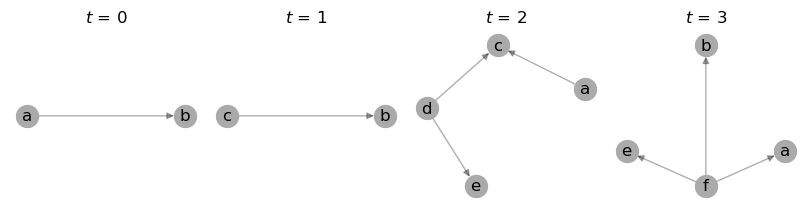

In [11]:
TG = tx.from_static(G).slice(attr="time", attr_level="edge", bins=None, qcut=None)
tx.draw(TG, layout="kamada_kawai", figsize=(8, 2))

#### Node-level time attribute

Converting a static graph with node-level temporal data to a temporal graph object:

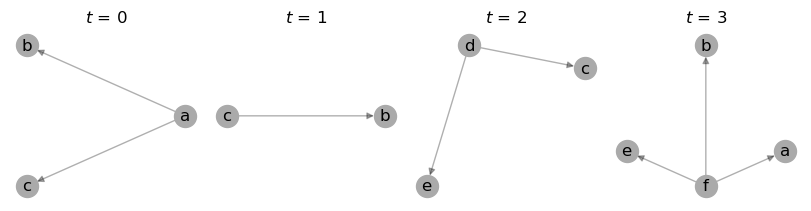

In [12]:
TG = tx.from_static(G).slice(attr="time", attr_level="node")
tx.draw(TG, layout="kamada_kawai", figsize=(8, 2))

Note that even though the edge $(a, c)$ contains the attribute `time=2`, considering node-level
attributes resulted in it being placed at $t=0$ instead, as the source node $a$ is set to `time=0`:

In [13]:
G.nodes(data="time")["a"]

0

> By default, the source node's temporal attribute is used to determine the time step of an edge.
> This behavior can be changed by setting ``node_level='target'`` instead.

### Convert to directed or undirected

We can easily convert the edge directions by calling the same methods available from `networkx`:

In [14]:
TG.to_undirected()

TemporalMultiGraph (t=4) with 12 nodes and 8 edges

In [15]:
TG.to_directed()

TemporalMultiDiGraph (t=4) with 12 nodes and 16 edges

___

## Common metrics

All methods implemented by `networkx`, e.g., `degree`, are also available to be executed sequentially on the stored time slices.

A few additional methods that consider all time slices are also implemented for convenience, e.g., `temporal_degree` and `temporal_neighbors`.

### Degree centrality

Functions such as ``degree``, ``in_degree``, ``out_degree`` return a list of degree views for each snapshot:

In [16]:
TG.degree()
# TG.in_degree()
# TG.out_degree()

[DiMultiDegreeView({'a': 4, 'b': 2, 'c': 2}),
 DiMultiDegreeView({'b': 2, 'c': 2}),
 DiMultiDegreeView({'c': 2, 'd': 4, 'e': 2}),
 DiMultiDegreeView({'a': 2, 'b': 2, 'e': 2, 'f': 6})]

Alternatively, to obtain the degree of a specific node:

In [17]:
TG[0].degree("a")
# TG[0].in_degree("a")
# TG[0].out_degree("a")

4

#### Temporal degree centrality

Meanwhile, ``temporal_degree`` returns a dictionary containing node degrees across all time steps:

In [18]:
TG.temporal_degree()
# TG.temporal_in_degree()
# TG.temporal_out_degree()

{'e': 4, 'a': 6, 'f': 6, 'b': 6, 'c': 6, 'd': 4}

Likewise, to obtain the degree of a specific node:

In [19]:
TG.temporal_degree("a")
# TG.temporal_in_degree("a")
# TG.temporal_out_degree("a")

6

### Order and size

Obtaining the number of nodes and edges in each snapshot:

In [20]:
print("Order:", TG.order())
print("Size:", TG.size())

Order: [3, 2, 3, 4]
Size: [4, 2, 4, 6]


#### Temporal order and size

Differently to the above, the ``temporal_order`` and ``temporal_size`` functions return the total number of nodes and edges across all time steps, **without** considering duplicated nodes across snapshots:

In [21]:
print("Temporal nodes:", TG.temporal_order())
print("Temporal edges:", TG.temporal_size())

Temporal nodes: 6
Temporal edges: 16


> The temporal order and size are respectively defined as the length of ``TG.temporal_nodes()``, i.e., set of all nodes over time, and the length of ``TG.temporal_size()``, i.e., sum of all their edges.

#### Total number of nodes and edges

Obtaining the actual number of nodes and edges across all snapshots, **with** duplicates:

In [22]:
print("Total nodes:", TG.total_nodes())  # TG.total_nodes() != TG.temporal_order()
print("Total edges:", TG.total_edges())  # TG.total_edges() == TG.temporal_size()

Total nodes: 12
Total edges: 16


The total nodes and edges are respectively defined as the sum of ``TG.nodes()`` lengths, i.e., nodes in each snapshot, and the sum of ``TG.edges()`` lengths, i.e., edges in each snapshot.

### Node neighborhoods

The ``neighbors`` method returns a list of neighbors for each node in each snapshot:

In [23]:
TG.neighbors("c")

[['a'], ['b'], ['d'], []]

#### Temporal node neighborhoods

The ``temporal_neighbors`` method returns a dictionary containing node neighbors in all snapshots:

In [24]:
TG.temporal_neighbors("c")

{'a', 'b', 'd'}

___

## Convert graph object

Static graphs may be converted to a different object type by calling `convert` with the format:

In [25]:
tx.convert(G, "igraph")

Support for the following packages are implemented:

| Format | Parameter (Package) | Parameter (Alias) |
| --- | :---: | :---: |
| [Deep Graph Library](https://www.dgl.ai/) | `dgl` | -
| [graph-tool](https://graph-tool.skewed.de/) | `graph_tool` | `gt`
| [igraph](https://igraph.org/python/) | `igraph` | `ig`
| [NetworKit](https://networkit.github.io/) | `networkit` | `nk`
| [PyTorch Geometric](https://pytorch-geometric.readthedocs.io) | `torch_geometric` | `pyg`
| [Teneto](https://teneto.readthedocs.io) | `teneto` | -

> Currently, only static graphs of `networkx` type are accepted as input for converion.


___

## Transform graph representation

Once a temporal graph is instantiated, the following methods allow returning static graphs, snapshots, events or unified representations.

Due to the way the underlying data is represented, some of these objects (i.e., those with unique nodes) do not allow dynamic node attributes.

Observe that the total number of nodes :math:`V` and edges :math:`E` of the returned object might differ from the number of
temporal nodes :math:`V_T` and edges :math:`E_T`, depending on the data and method used:

| Method | Order | Size | Dynamic node attributes | Dynamic edge attributes |
| --- | :---: | :---: | :---: | :---: |
| `to_static` | $V = V_T$ | $E = E_T$ | ❌ | ✅ |
| `to_snapshots` | $V \ge V_T$ | $E = E_T$ | ✅ | ✅ |
| `to_events` | $V = V_T$ | $E = E_T$ | ❌ | ❌ |
| `to_unified` | $V \ge V_T$ | $E \ge E_T$ | ✅ | ✅ |


### Static graph

Builds a static or flattened graph ``G`` containing all the edges found at each time step.

> Any dynamic node attributes in the temporal graph are **not** preserved in the resulting object.

#### TemporalGraph → G

In [26]:
G = TG.to_static()
G

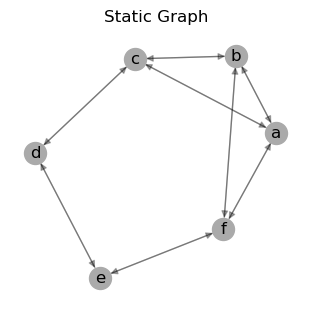

In [27]:
tx.draw(G, layout="kamada_kawai", suptitle="Static Graph")

#### G → TemporalGraph

In [28]:
TG = tx.from_static(G).slice(attr="time")
TG

TemporalMultiDiGraph (t=4) with 12 nodes and 16 edges

### Snapshot-based temporal graph

A snapshot-based temporal graph ``STG`` is a sequence of graphs where each element represents a snapshot of the original temporal graph. It is the most common representation of temporal graphs.

> Much like the ``slice`` method, this function internally returns views of the original graph data, so no data is copied unless specified otherwise (i.e., by calling ``as_view=False``).

#### TemporalGraph → STG

In [29]:
STG = TG.to_snapshots()
STG

#### STG → TemporalGraph

In [30]:
TG = tx.from_snapshots(STG)
TG

TemporalMultiDiGraph (t=4) with 12 nodes and 16 edges

### Event-based temporal graph

An event-based temporal graph (ETG) is a sequence of 3- or 4-tuple edge-based events.

* **3-tuples** ($u, v, t$), where elements are the source node, target node, and time attribute;

* **4-tuples** ($u, v, t, \epsilon$), where an additional emenet $\epsilon$ is either a positive (1) or negative (-1) unity representing edge addition and deletion events, respectively.

> Depending on the temporal graph data, one of these may allow a more compact representation than the other. The default is to return a 3-tuple sequence (also known as a *stream graph*).

>Event-based temporal graphs do not currently store node- or edge-level attribute data.

#### TemporalGraph → ETG

In [31]:
ETG = TG.to_events()  # stream=True (default)
ETG

[('b', 'a', 0),
 ('a', 'b', 0),
 ('b', 'c', 1),
 ('c', 'b', 1),
 ('a', 'c', 2),
 ('c', 'a', 2),
 ('c', 'd', 2),
 ('d', 'c', 2),
 ('d', 'e', 2),
 ('e', 'd', 2),
 ('a', 'f', 3),
 ('b', 'f', 3),
 ('e', 'f', 3),
 ('f', 'e', 3),
 ('f', 'a', 3),
 ('f', 'b', 3)]

In [32]:
ETG = TG.to_events(stream=False)
ETG

[('b', 'a', 0, 1),
 ('a', 'b', 0, 1),
 ('b', 'c', 1, 1),
 ('c', 'b', 1, 1),
 ('b', 'a', 1, -1),
 ('a', 'b', 1, -1),
 ('a', 'c', 2, 1),
 ('c', 'a', 2, 1),
 ('c', 'd', 2, 1),
 ('d', 'c', 2, 1),
 ('d', 'e', 2, 1),
 ('e', 'd', 2, 1),
 ('b', 'c', 2, -1),
 ('c', 'b', 2, -1),
 ('a', 'f', 3, 1),
 ('b', 'f', 3, 1),
 ('e', 'f', 3, 1),
 ('f', 'e', 3, 1),
 ('f', 'a', 3, 1),
 ('f', 'b', 3, 1),
 ('a', 'c', 3, -1),
 ('c', 'a', 3, -1),
 ('c', 'd', 3, -1),
 ('d', 'c', 3, -1),
 ('d', 'e', 3, -1),
 ('e', 'd', 3, -1)]

#### ETG → TemporalGraph  

In [33]:
tx.from_events(ETG, directed=True, multigraph=True)

TemporalMultiDiGraph (t=4) with 12 nodes and 16 edges

### Unified temporal graph

A unified temporal graph ``UTG`` is a single graph object that contains the original temporal data,
plus ''proxy'' nodes (*from each snapshot*) and edge ''couplings'' (*linking sequential temporal nodes*).

Its usefulness is restricted to certain types of analysis and visualization, e.g., based on temporal flows.

#### UTG → TemporalGraph

In [34]:
UTG = TG.to_unified(add_couplings=True)
print(UTG)

MultiDiGraph named 'UTG (t=4, proxy_nodes=6, edge_couplings=10)' with 12 nodes and 22 edges


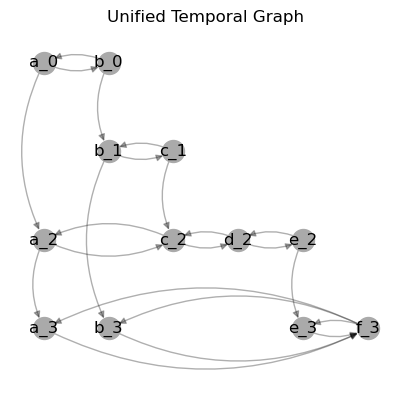

In [35]:
nodes = sorted(TG.temporal_nodes())

pos = {node: (nodes.index(node.rsplit("_")[0]), -int(node.rsplit("_")[1]))
         for node in UTG.nodes()}

tx.draw(UTG,
        pos=pos,
        figsize=(4, 4),
        connectionstyle="arc3,rad=0.25",
        suptitle="Unified Temporal Graph")

#### UTG → TemporalGraph  

In [36]:
tx.from_unified(UTG)

TemporalMultiDiGraph (t=4) with 12 nodes and 16 edges

___

## Community detection

As a toy example, let's first use the simplest
[Stochastic Block Model](https://networkx.org/documentation/stable/reference/generated/networkx.generators.community.stochastic_block_model.html)
to generate 4 graph snapshots, in which each of the 5 clusters of 5 nodes each continuously mix together over time:

In [37]:
snapshots = 4   # Temporal graphs to generate.
clusters = 5    # Number of clusters/communities.
order = 5       # Nodes in each cluster.
intra = .9      # High initial probability of intra-community edges.
inter = .1      # Low initial probability of inter-community edges.
change = .125   # Change in intra- and inter-community edges over time.

# Get probability matrix for each snapshot.
probs = [[[
    (intra if i == j else inter) + (t * change * (-1 if i == j else 1))
    for j in range(clusters)]
    for i in range(clusters)]
    for t in range(snapshots)]

# Create graphs from probabilities.
graphs = {}
for t in range(snapshots):
    graphs[t] = nx.stochastic_block_model(clusters*[order], probs[t], seed=10)
    graphs[t].name = t

# Create temporal graph from snapshots.
TG = tx.from_snapshots(graphs)

Let's plot the graphs, with node colors representing communities and intra-community edges:

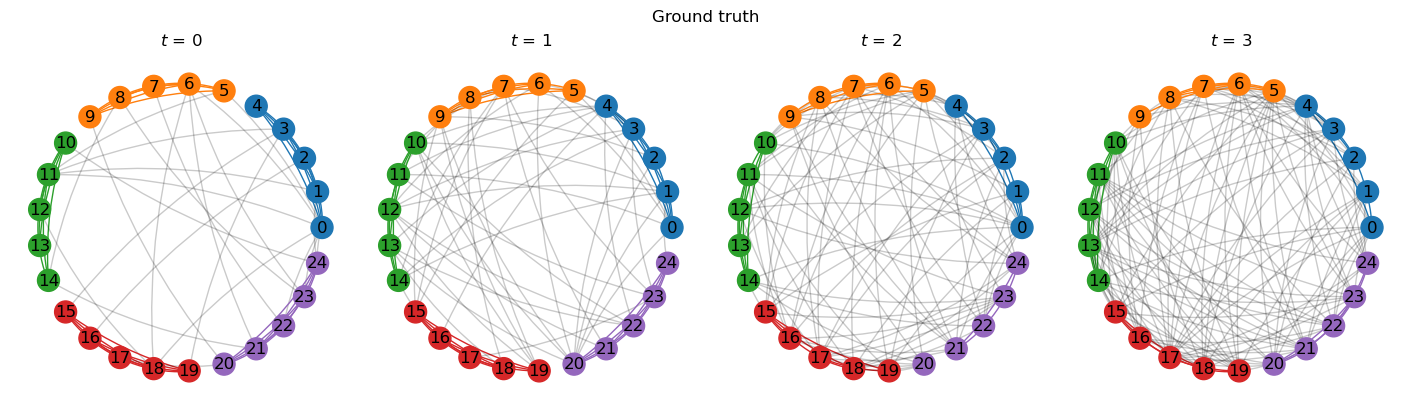

In [38]:
import matplotlib.pyplot as plt

def get_edge_color(edges: list, node_color: dict):
    return [node_color[u]
            if node_color[u] == node_color[v]
            else "#00000035"
            for u, v in edges]

c = plt.cm.tab10.colors

# Node positions.
pos = nx.circular_layout(TG.to_static())

# Community ground truths.
node_color = [c[i // clusters] for i in range(TG.temporal_order())]

# Colorize intra-community edges.
temporal_opts = {t: {"edge_color": get_edge_color(TG[t].edges(), node_color)}
                 for t in range(len(TG))}

# Plot snapshots with community ground truths.
tx.draw(
    TG,
    pos=pos,
    figsize=(14, 4),
    node_color=node_color,
    temporal_opts=temporal_opts,
    connectionstyle="arc3,rad=0.1",
    suptitle="Ground truth")

We see the graphs are generated with the same community structure, but continuously decreasing assortativity.

Let's try and retrieve these communities using a modularity optimization algorithm.

> Optimizations algorithms may help with descriptive or exploratory tasks and post-hoc network
> analysis, but lack statistical rigor for inferential purposes. See [Peixoto (2021)](https://skewed.de/tiago/posts/descriptive-inferential) for a discussion.


### Modularity: on static graph

The [leidenalg](https://leidenalg.readthedocs.io) package implements optimization algorithms for community detection may be applied on snapshot-based temporal graphs, allowing to better capture their underlying structure.

For example, depending on the initial node community assigments (e.g., with `seed=0` below), [modularity](https://leidenalg.readthedocs.io/en/stable/reference.html#modularityvertexpartition) fails to retrieve the true communities (their ground truths) in the network:

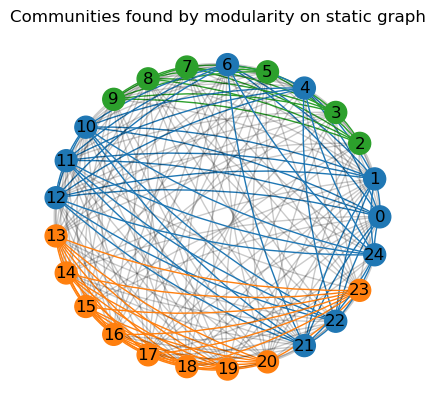

In [39]:
import leidenalg as la

membership = la.find_partition(
    TG.to_static("igraph"),
    la.ModularityVertexPartition,
    n_iterations=-1,
    seed=0,
)

node_color = [c[m] for m in membership.membership]
edge_color = get_edge_color(TG.to_static().edges(), node_color)

tx.draw(
    TG.to_static(),
    pos=pos,
    figsize=(4, 4),
    node_color=node_color,
    edge_color=edge_color,
    connectionstyle="arc3,rad=0.1",
    suptitle="Communities found by modularity on static graph")

Although two communities are correctly retrieved (in red and green), nodes :math:`0` to :math:`4`,
which form a fifth community in the network, are misclassified as belonging to the blue and orange
communities.

Next, let's try and exploit the network's temporal information to improve on these results.

### Modularity: on each snapshot

Running the same algorithm separately on each of the generated snapshots retrieves the correct clusters only on the first graph ($t=0$).
This is mostly due to modularity optimization expecting an assortative community structure, which is not present in the later snapshots, as they mix together.

In addition, community indices (represented by their colors) are not fixed over snapshots, which makes understanding their mesoscale dynamics harder.
This is illustrated in the plot below:

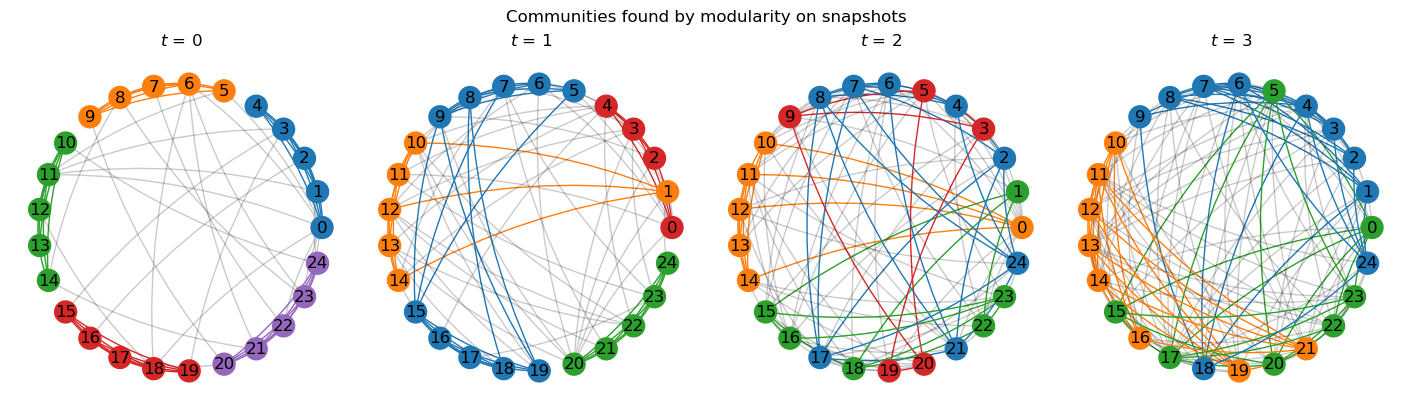

In [40]:
temporal_opts = {}

for t in range(len(TG)):
    membership = la.find_partition(
        TG[t:t+1].to_static("igraph"),
        la.ModularityVertexPartition,
        n_iterations=-1,
        seed=0,
    )
    node_color = [c[m] for m in membership.membership]
    edge_color = get_edge_color(TG[t].edges(), node_color)
    temporal_opts[t] = {"node_color": node_color, "edge_color": edge_color}

tx.draw(
    TG,
    pos=pos,
    figsize=(14, 4),
    temporal_opts=temporal_opts,
    connectionstyle="arc3,rad=0.1",
    suptitle="Communities found by modularity on snapshots")

Not only the results of subsequent snapshots are suboptimal, it is also particularly hard to track
the evolution of communities over time to analyze a network's temporal mesoscale dynamics.


### Modularity: on temporal graph

[Coupling temporal nodes](https://leidenalg.readthedocs.io/en/stable/multiplex.html#slices-to-layers) allows the same algorithm to correctly retrieve the ground truths in this case, while at the same time maintaining community indices consistent over time, as seen below:

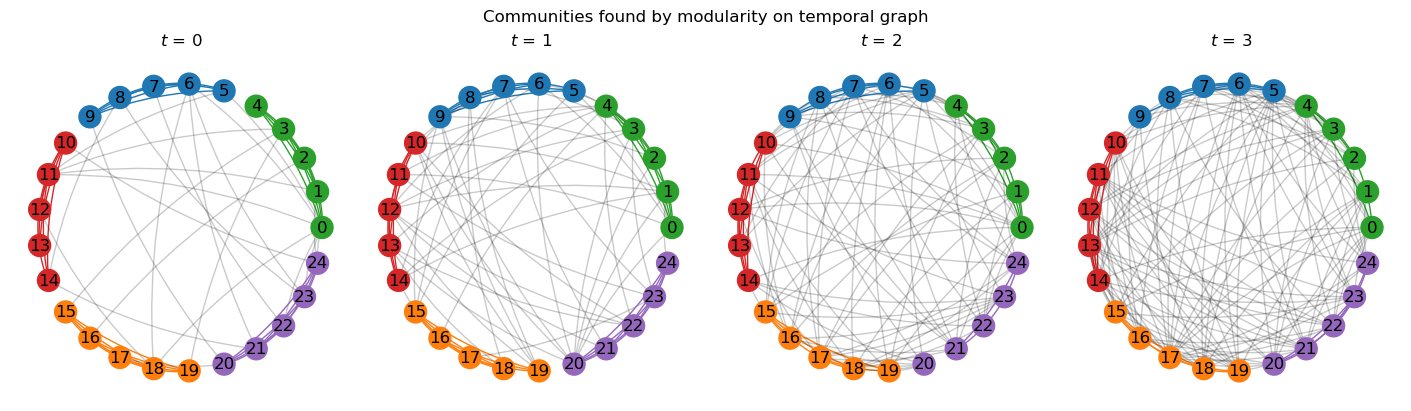

In [41]:
temporal_opts = {}

temporal_membership, improvement = la.find_partition_temporal(
    TG.to_snapshots("igraph"),
    la.ModularityVertexPartition,
    interslice_weight=1.0,
    n_iterations=-1,
    seed=0,
    vertex_id_attr="_nx_name"
)

for t in range(len(TG)):
    node_color = [c[m] for m in temporal_membership[t]]
    edge_color = get_edge_color(TG[t].edges(), node_color)
    temporal_opts[t] = {"node_color": node_color, "edge_color": edge_color}

tx.draw(
    TG,
    figsize=(14, 4),
    pos=pos,
    temporal_opts=temporal_opts,
    connectionstyle="arc3,rad=0.1",
    suptitle="Communities found by modularity on temporal graph")

This method is particularly useful to track communities over time, as it allows to maintain the
same community indices across snapshots, potentially contributing to the study of their dynamics.

Although very simple, this example showcased how considering a network's temporal information can benefit
its analysis, as well as help to better understand and visualize its mesoscale structures.

___

## References

- [Deep Graph Library](https://www.dgl.ai/)
- [graph-tool](https://graph-tool.skewed.de/)
- [igraph](https://igraph.org/python/)
- [Leiden](https://leidenalg.readthedocs.io)
- [NetworKit](https://networkit.github.io/)
- [NetworkX](https://networkx.github.io)
- [Pandas](https://pandas.pydata.org/)
- [PyTorch Geometric](https://pytorch-geometric.readthedocs.io)
- [Teneto](https://teneto.readthedocs.io)